In [1]:
#Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from urllib.request import urlretrieve
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin


In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=None, criterion="entropy"):
        self.max_depth = max_depth
        self.criterion = criterion
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        unique_labels = np.unique(y)

        if len(unique_labels) == 1 or (self.max_depth and depth >= self.max_depth):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._best_split(X, y, num_features)

        if best_feature is None:
            return Node(value=self._most_common_label(y))

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices

        left_subtree = self._grow_tree(X[left_indices], y[left_indices], depth + 1) if len(y[left_indices]) > 0 else Node(value=self._most_common_label(y))
        right_subtree = self._grow_tree(X[right_indices], y[right_indices], depth + 1) if len(y[right_indices]) > 0 else Node(value=self._most_common_label(y))
# If a split results in an empty branch (i.e., no samples on one side), assign the most common label from the current node as a leaf value to avoid errors and ensure
#the tree remains valid.


        return Node(best_feature, best_threshold, left_subtree, right_subtree)

    def _best_split(self, X, y, num_features):
        best_impurity = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                impurity = self._calculate_impurity(X[:, feature], y, threshold)
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_impurity(self, feature_column, y, threshold):
        left_indices = feature_column <= threshold
        right_indices = ~left_indices

        left_impurity = self._impurity(y[left_indices])
        right_impurity = self._impurity(y[right_indices])

        left_weight = np.sum(left_indices) / len(y)
        right_weight = np.sum(right_indices) / len(y)

        return left_weight * left_impurity + right_weight * right_impurity

    def _impurity(self, y):
        if self.criterion == "gini":
            return self._gini(y)
        return self._entropy(y)

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return 1 - np.sum(probabilities ** 2)

    def _most_common_label(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

In [3]:
# Download datasets
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"  #KDD cup'99 dataset
filename = "kddcup.data_10_percent.gz"
urlretrieve(url, filename)

train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt" #Train Dataset of NSL-KDD Dataset
test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"   #Test dataset of NSL-KDD Dataset

train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

if not os.path.exists(filename):
    print("Downloading 10% KDD Cup'99 dataset...")
    urlretrieve(train_url, train_file)
if not os.path.exists(train_file):
    print("Downloading training dataset of NSL-KDD...")
    urlretrieve(train_url, train_file)
if not os.path.exists(test_file):
    print("Downloading testing dataset of NSL-KDD...")
    urlretrieve(test_url, test_file)


In [4]:
#Function written to plot confusion matrix using matplotlib and seaborn
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [5]:
def calculateAndDisplayEvaluationMetrics(y_test, y_pred,title):
    accuracy = accuracy_score(y_test,y_pred)*100
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plot_confusion_matrix(y_test, y_pred, title)

In [20]:
# (a) KDD Cup '99

# Setting column names from dataset description
KDDCup_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Loading dataset in dataframe using pandas
df = pd.read_csv(filename, names=KDDCup_columns)

#Removes duplicate rows(data cleaning)
df = df.drop_duplicates()

print(df.shape)

(145586, 42)


In [7]:
print(df['label'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a
#Clearly, we can see that this daataset is very skewed and imbalanced

{'normal.': 87832, 'neptune.': 51820, 'back.': 968, 'teardrop.': 918, 'satan.': 906, 'warezclient.': 893, 'ipsweep.': 651, 'smurf.': 641, 'portsweep.': 416, 'pod.': 206, 'nmap.': 158, 'guess_passwd.': 53, 'buffer_overflow.': 30, 'warezmaster.': 20, 'land.': 19, 'imap.': 12, 'rootkit.': 10, 'loadmodule.': 9, 'ftp_write.': 8, 'multihop.': 7, 'phf.': 4, 'perl.': 3, 'spy.': 2}


In [21]:
# Convert categorical columns using Label Encoding (since, ML Models can only take in numerical features and not text)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Converting labels to binary, ie, 0 if normal and 1 if attack
df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

X = df.drop("label", axis=1).values # Extracting features
y = df["label"].values #Extracting labels

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 80% train, 20% test dataset split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 70% train and 30% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full)

In [22]:
#Decision Tree from scratch
#Hyperparameter on the validation set

criteria = ['entropy', 'gini']
depth_range = range(3, 8)

best_f1 = 0
best_depth = None
best_criterion = None
best_model = None

f1_scores_dict = {
    'entropy': [],
    'gini': []
}

for criterion in criteria:
    print(f"\nEvaluating criterion: {criterion.upper()}")
    for depth in depth_range:
        model = DecisionTree(max_depth=depth, criterion=criterion)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)

        # Compute F1 score on validation set
        f1 = f1_score(y_val, y_val_pred)
        f1_scores_dict[criterion].append(f1)
        print(f"Max Depth = {depth} | F1 Score = {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_criterion = criterion
            best_model = model

# Final best evaluation
print("\nBest configuration:")
print(f"Best Criterion: {best_criterion}")
print(f"Best Max Depth: {best_depth}")
print(f"F1 Score (Validation): {best_f1:.4f}")


Evaluating criterion: ENTROPY
Max Depth = 3 | F1 Score = 0.9700
Max Depth = 4 | F1 Score = 0.9800
Max Depth = 5 | F1 Score = 0.9809
Max Depth = 6 | F1 Score = 0.9909
Max Depth = 7 | F1 Score = 0.9930

Evaluating criterion: GINI
Max Depth = 3 | F1 Score = 0.9704
Max Depth = 4 | F1 Score = 0.9781
Max Depth = 5 | F1 Score = 0.9868
Max Depth = 6 | F1 Score = 0.9890
Max Depth = 7 | F1 Score = 0.9926

Best configuration:
Best Criterion: entropy
Best Max Depth: 7
F1 Score (Validation): 0.9930


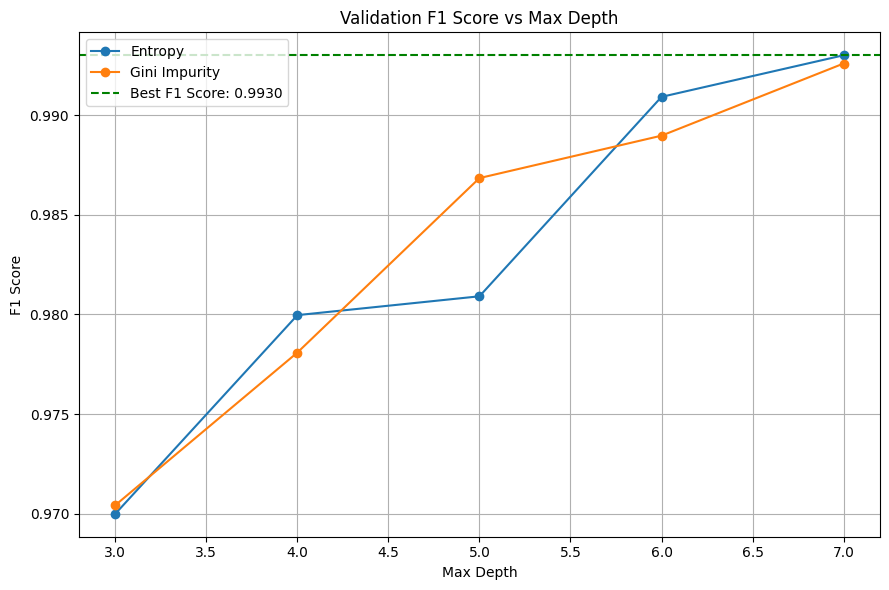

In [23]:
# Plotting
plt.figure(figsize=(9, 6))
for criterion in criteria:
    label_name = "Gini Impurity" if criterion == 'gini' else criterion.capitalize()
    plt.plot(depth_range, f1_scores_dict[criterion], marker='o', label=label_name)

plt.axhline(best_f1, color='green', linestyle='--', label=f"Best F1 Score: {best_f1:.4f}")
plt.title('Validation F1 Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')  # Set legend to top right
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation on Training Set
Model Accuracy: 99.48%
Precision: 0.9991
Recall: 0.9877
F1 Score: 0.9934


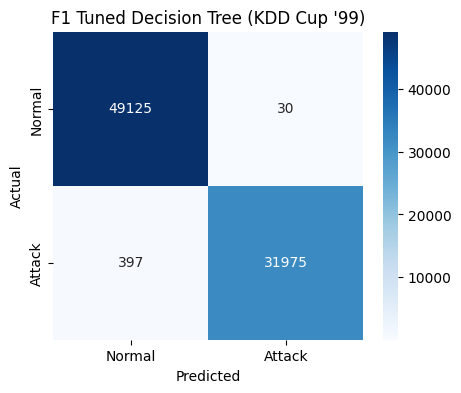


Evaluation on Validation Set
Model Accuracy: 99.45%
Precision: 0.9985
Recall: 0.9875
F1 Score: 0.9930


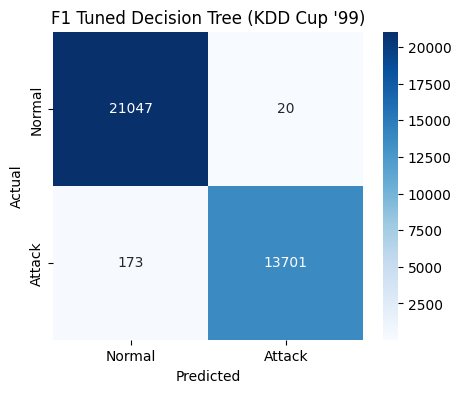


Evaluation on Test Set
Model Accuracy: 99.42%
Precision: 0.9987
Recall: 0.9865
F1 Score: 0.9926


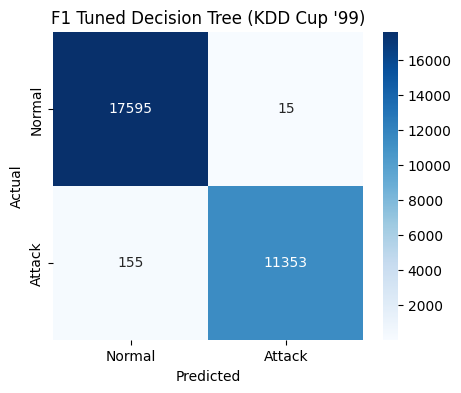

In [24]:
#Training the final model on the best parameters
final_model = DecisionTree(max_depth=best_depth, criterion=best_criterion)
final_model.fit(X_train, y_train)

# Evaluate on training set
print("\nEvaluation on Training Set")
y_pred_train = final_model.predict(X_train)
calculateAndDisplayEvaluationMetrics(y_train, y_pred_train, "F1 Tuned Decision Tree (KDD Cup '99)")

# Evaluate on validation set
print("\nEvaluation on Validation Set")
y_pred_val = final_model.predict(X_val)
calculateAndDisplayEvaluationMetrics(y_val, y_pred_val, "F1 Tuned Decision Tree (KDD Cup '99)")

# Evaluate on test set
print("\nEvaluation on Test Set")
y_pred_test = final_model.predict(X_test)
calculateAndDisplayEvaluationMetrics(y_test, y_pred_test, "F1 Tuned Decision Tree (KDD Cup '99)")


Evaluating criterion: ENTROPY
Max Depth = 3 | F1 Score (Val) = 0.9700
Max Depth = 4 | F1 Score (Val) = 0.9803
Max Depth = 5 | F1 Score (Val) = 0.9813
Max Depth = 6 | F1 Score (Val) = 0.9899
Max Depth = 7 | F1 Score (Val) = 0.9933
Max Depth = 8 | F1 Score (Val) = 0.9974
Max Depth = 9 | F1 Score (Val) = 0.9979
Max Depth = 10 | F1 Score (Val) = 0.9985
Max Depth = 11 | F1 Score (Val) = 0.9986
Max Depth = 12 | F1 Score (Val) = 0.9986
Max Depth = 13 | F1 Score (Val) = 0.9985

Evaluating criterion: GINI
Max Depth = 3 | F1 Score (Val) = 0.9738
Max Depth = 4 | F1 Score (Val) = 0.9773
Max Depth = 5 | F1 Score (Val) = 0.9871
Max Depth = 6 | F1 Score (Val) = 0.9935
Max Depth = 7 | F1 Score (Val) = 0.9950
Max Depth = 8 | F1 Score (Val) = 0.9978
Max Depth = 9 | F1 Score (Val) = 0.9979
Max Depth = 10 | F1 Score (Val) = 0.9982
Max Depth = 11 | F1 Score (Val) = 0.9982
Max Depth = 12 | F1 Score (Val) = 0.9983
Max Depth = 13 | F1 Score (Val) = 0.9983

Best Parameters (for F1 Score): {'max_depth': 11, 'c

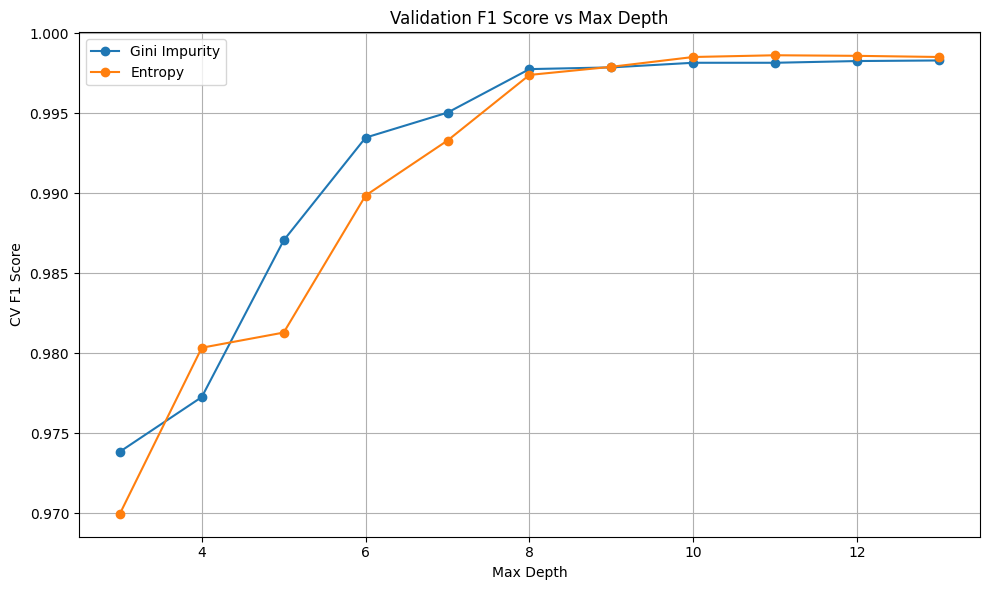

In [9]:
#Comparing with sklearn
# Define the parameter grid
depth_range = list(range(3, 14))
criteria = ['entropy', 'gini']

# Track the best config
best_f1 = 0
best_depth = None
best_criterion = None
best_model = None

# Store F1 scores for plotting
f1_scores_dict = {
    'entropy': [],
    'gini': []
}

# Manual tuning on validation set
for criterion in criteria:
    print(f"\nEvaluating criterion: {criterion.upper()}")
    for depth in depth_range:
        clf = DecisionTreeClassifier(max_depth=depth, criterion=criterion, class_weight='balanced')
        clf.fit(X_train, y_train)

        y_val_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_val_pred)
        f1_scores_dict[criterion].append(f1)
        print(f"Max Depth = {depth} | F1 Score (Val) = {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_criterion = criterion
            best_model = clf


print()
# Final results
print("Best Parameters (for F1 Score):", {'max_depth': best_depth, 'criterion': best_criterion})
print("Best Validation F1 Score:", best_f1)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(depth_range, f1_scores_dict['gini'], label='Gini Impurity', marker='o')
plt.plot(depth_range, f1_scores_dict['entropy'], label='Entropy', marker='o')

plt.xlabel('Max Depth')
plt.ylabel('CV F1 Score')
plt.title('Validation F1 Score vs Max Depth')
plt.legend(loc='upper left')  # <--- Set legend position to top-right
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation on Training Set
Model Accuracy: 99.96%
Precision: 0.9998
Recall: 0.9991
F1 Score: 0.9995


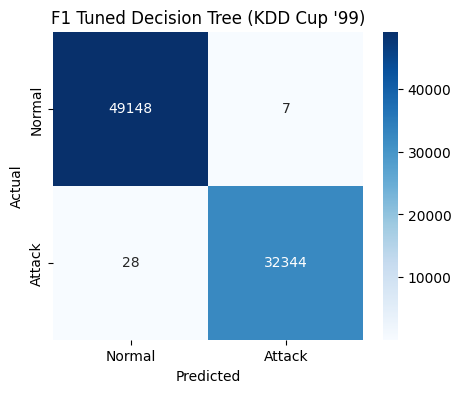


Evaluation on Validation Set
Model Accuracy: 99.89%
Precision: 0.9990
Recall: 0.9982
F1 Score: 0.9986


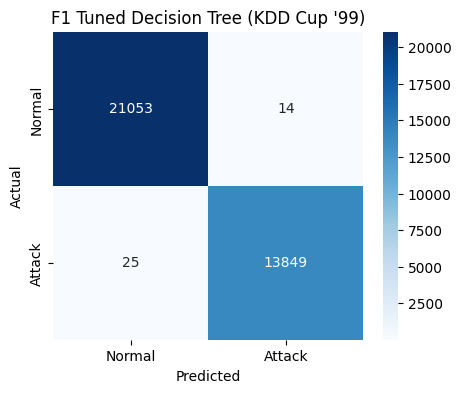


Evaluation on Test Set
Model Accuracy: 99.89%
Precision: 0.9989
Recall: 0.9984
F1 Score: 0.9987


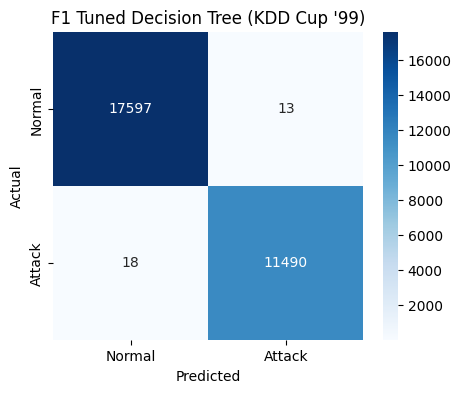

In [10]:
# Retrain the best model on the training set only
final_model = DecisionTreeClassifier(
    max_depth=best_depth,
    criterion=best_criterion,
    class_weight='balanced',
    random_state=42
)
final_model.fit(X_train, y_train)

# Evaluation on Training Set
print("\nEvaluation on Training Set")
y_pred_train = final_model.predict(X_train)
calculateAndDisplayEvaluationMetrics(y_train, y_pred_train, "F1 Tuned Decision Tree (KDD Cup '99)")

# Evaluation on Validation Set
print("\nEvaluation on Validation Set")
y_pred_val = final_model.predict(X_val)
calculateAndDisplayEvaluationMetrics(y_val, y_pred_val, "F1 Tuned Decision Tree (KDD Cup '99)")

# Evaluation on Test Set
print("\nEvaluation on Test Set")
y_pred_test = final_model.predict(X_test)
calculateAndDisplayEvaluationMetrics(y_test, y_pred_test, "F1 Tuned Decision Tree (KDD Cup '99)")

In [13]:
# (b) ON the NSL-KDD Dataset with Validation Split
KDDNSL_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "class", "difficulty"
]

train_df = pd.read_csv(train_file, names=KDDNSL_columns, header=None)
test_df = pd.read_csv(test_file, names=KDDNSL_columns, header=None)

# Dropping the difficulty column as it's irrelevant for training
train_df.drop("difficulty", axis=1, inplace=True)
test_df.drop("difficulty", axis=1, inplace=True)

print(train_df['class'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count
# Clearly, we can see that this dataset is more balanced

# Label encode categorical columns (to convert features to numerical values)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()

for col in categorical_cols:
    train_df[col] = encoder.fit_transform(train_df[col])  # Fit + transform on train
    test_df[col] = encoder.transform(test_df[col])  # Transform only on test (NO FIT)

# Convert class labels to binary (0 for normal, 1 for attack)
train_df["class"] = train_df["class"].apply(lambda x: 0 if x == "normal" else 1)
test_df["class"] = test_df["class"].apply(lambda x: 0 if x == "normal" else 1)

# Split features and labels
X_full = train_df.drop("class", axis=1).values
y_full = train_df["class"].values
X_test = test_df.drop("class", axis=1).values
y_test = test_df["class"].values

# Standardize features
scaler = StandardScaler()
X_full = scaler.fit_transform(X_full)
X_test = scaler.transform(X_test)

print(X_full.shape)
print(X_test.shape)

# Split the original training set into train and validation sets (70-30)
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

{'normal': 67343, 'neptune': 41214, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'guess_passwd': 53, 'buffer_overflow': 30, 'warezmaster': 20, 'land': 18, 'imap': 11, 'rootkit': 10, 'loadmodule': 9, 'ftp_write': 8, 'multihop': 7, 'phf': 4, 'perl': 3, 'spy': 2}
(125973, 41)
(22544, 41)


In [17]:
#Decision Tree from scratch (NSL-KDD)
#Hyperparamter Tuning

criteria = ['entropy', 'gini']
depth_range = range(3, 8)

best_f1 = 0
best_depth = None
best_criterion = None

f1_scores_dict = {
    'entropy': [],
    'gini': []
}

# Hyperparameter tuning on validation set
for criterion in criteria:
    print(f"\nEvaluating criterion: {criterion.upper()}")
    for depth in depth_range:
        model = DecisionTree(max_depth=depth, criterion=criterion)
        model.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)

        f1 = f1_score(y_val, y_pred_val)
        f1_scores_dict[criterion].append(f1)
        print(f"Max Depth = {depth} | Validation F1 Score = {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_depth = depth
            best_criterion = criterion

# Print best parameters
print("\nBest configuration (from validation tuning):")
print(f"Best Criterion: {best_criterion}")
print(f"Best Max Depth: {best_depth}")
print(f"Best Validation F1 Score: {best_f1:.4f}")


Evaluating criterion: ENTROPY
Max Depth = 3 | Validation F1 Score = 0.9586
Max Depth = 4 | Validation F1 Score = 0.9808
Max Depth = 5 | Validation F1 Score = 0.9852
Max Depth = 6 | Validation F1 Score = 0.9910
Max Depth = 7 | Validation F1 Score = 0.9938

Evaluating criterion: GINI
Max Depth = 3 | Validation F1 Score = 0.9656
Max Depth = 4 | Validation F1 Score = 0.9767
Max Depth = 5 | Validation F1 Score = 0.9808
Max Depth = 6 | Validation F1 Score = 0.9916
Max Depth = 7 | Validation F1 Score = 0.9936

Best configuration (from validation tuning):
Best Criterion: entropy
Best Max Depth: 7
Best Validation F1 Score: 0.9938


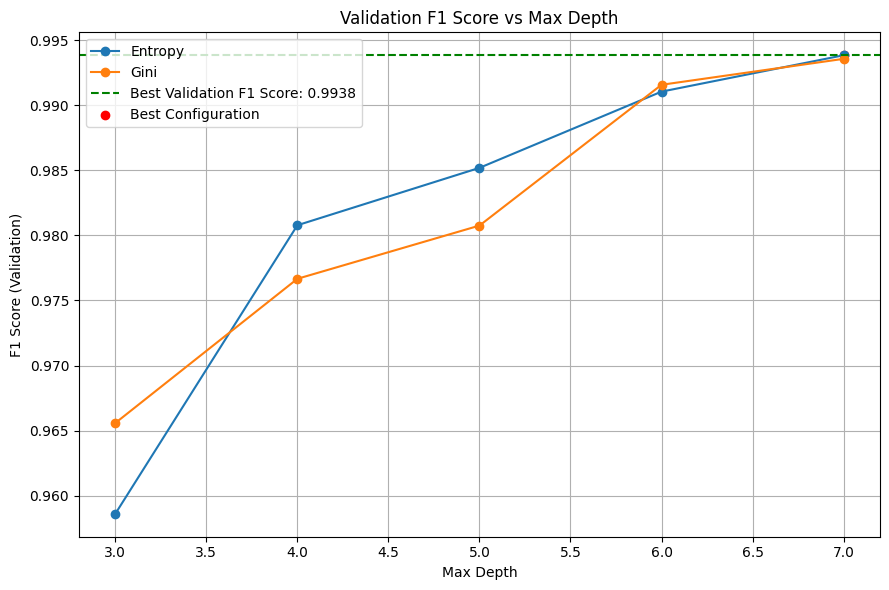

In [18]:
# Plotting
plt.figure(figsize=(9, 6))
for criterion in criteria:
    plt.plot(depth_range, f1_scores_dict[criterion], marker='o', label=f"{criterion.capitalize()}")

plt.axhline(best_f1, color='green', linestyle='--', label=f"Best Validation F1 Score: {best_f1:.4f}")
plt.scatter(best_depth, best_f1, color='red', label='Best Configuration')
plt.title('Validation F1 Score vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score (Validation)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation on Training Subset
Model Accuracy: 99.53%
Precision: 0.9964
Recall: 0.9934
F1 Score: 0.9949


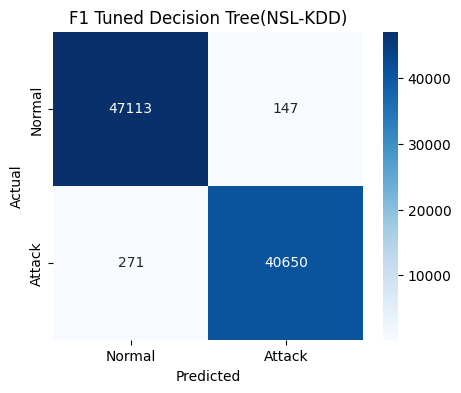


Evaluation on Validation Set
Model Accuracy: 99.42%
Precision: 0.9957
Recall: 0.9920
F1 Score: 0.9938


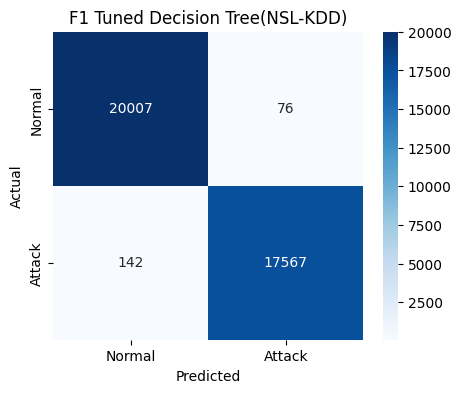


Evaluation on Test Set
Model Accuracy: 81.46%
Precision: 0.9657
Recall: 0.6992
F1 Score: 0.8111


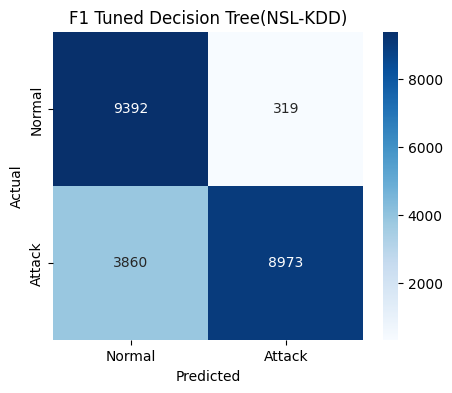

In [19]:
# Retrain final model on the training subset (70%) using best hyperparameters
final_model = DecisionTree(max_depth=best_depth, criterion=best_criterion)
final_model.fit(X_train, y_train)

# Evaluation on Training Subset
print("\nEvaluation on Training Subset")
y_pred_train = final_model.predict(X_train)
calculateAndDisplayEvaluationMetrics(y_train, y_pred_train, "F1 Tuned Decision Tree(NSL-KDD)")

# Evaluation on Validation Set
print("\nEvaluation on Validation Set")
y_pred_val = final_model.predict(X_val)
calculateAndDisplayEvaluationMetrics(y_val, y_pred_val, "F1 Tuned Decision Tree(NSL-KDD)")

# Evaluation on Test Set
print("\nEvaluation on Test Set")
y_pred_test = final_model.predict(X_test)
calculateAndDisplayEvaluationMetrics(y_test, y_pred_test, "F1 Tuned Decision Tree(NSL-KDD)")

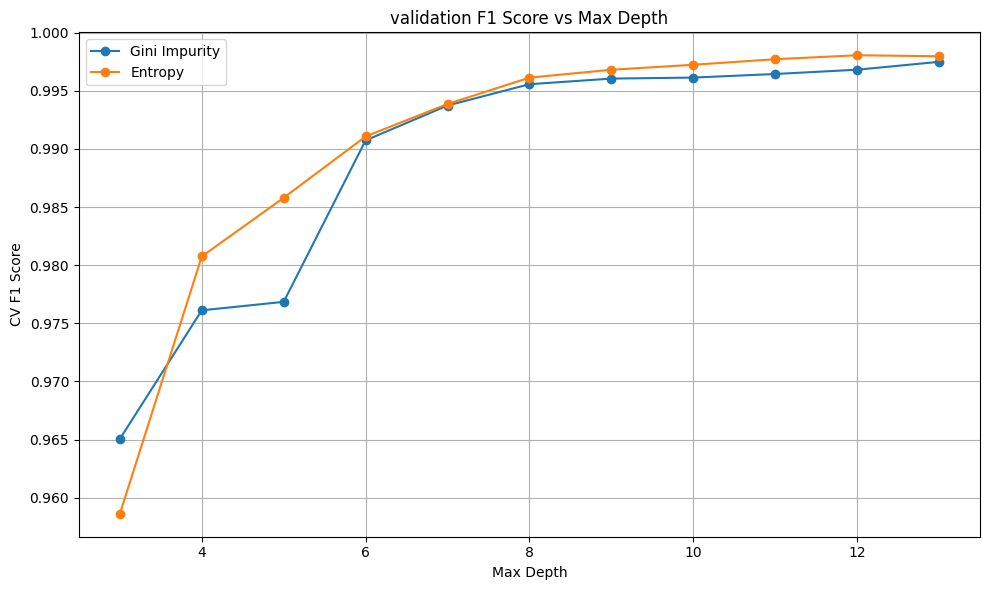


Best Parameters (for F1 Score): {'criterion': 'entropy', 'max_depth': 12}
Best Validation F1 Score: 0.9980514529383525


In [14]:
#Comaring with sklearn
# Define the parameter grid
param_grid = {
    'max_depth': list(range(3, 14)),
    'criterion': ['gini', 'entropy']
}

# Manual grid search with F1 score on validation set
best_score = 0
best_model = None
results = []

for criterion in param_grid['criterion']:
    for max_depth in param_grid['max_depth']:
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth,
                                     class_weight='balanced', random_state=42)
        clf.fit(X_train, y_train)
        y_val_pred = clf.predict(X_val)
        score = f1_score(y_val, y_val_pred)
        results.append({'criterion': criterion, 'max_depth': max_depth, 'mean_test_score': score})
        if score > best_score:
            best_score = score
            best_model = clf
            best_params = {'criterion': criterion, 'max_depth': max_depth}

# Get results as a DataFrame for easier analysis
import pandas as pd
results_df = pd.DataFrame(results)

# Separate scores by criterion
gini_scores = results_df[results_df['criterion'] == 'gini']
entropy_scores = results_df[results_df['criterion'] == 'entropy']

print()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gini_scores['max_depth'], gini_scores['mean_test_score'], label='Gini Impurity', marker='o')
plt.plot(entropy_scores['max_depth'], entropy_scores['mean_test_score'], label='Entropy', marker='o')

plt.xlabel('Max Depth')
plt.ylabel('CV F1 Score')
plt.title('validation F1 Score vs Max Depth')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print()
# Print best configuration and evaluate
print("Best Parameters (for F1 Score):", best_params)
print("Best Validation F1 Score:", best_score)


Evaluation on Training Set
Model Accuracy: 99.98%
Precision: 0.9998
Recall: 0.9998
F1 Score: 0.9998


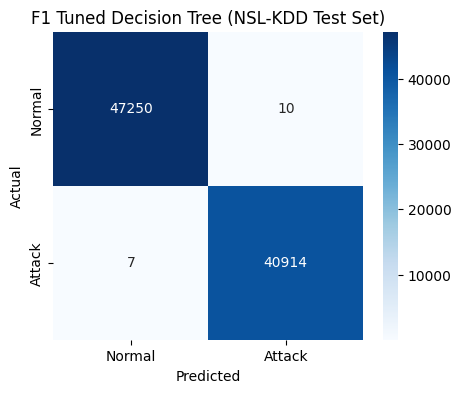


Evaluation on Validation Set
Model Accuracy: 99.82%
Precision: 0.9982
Recall: 0.9979
F1 Score: 0.9981


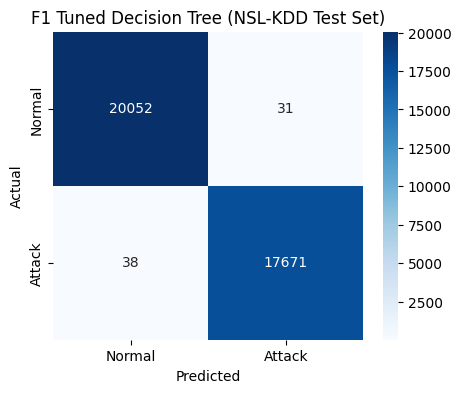


Evaluation on Test Set
Model Accuracy: 82.23%
Precision: 0.9685
Recall: 0.7109
F1 Score: 0.8199


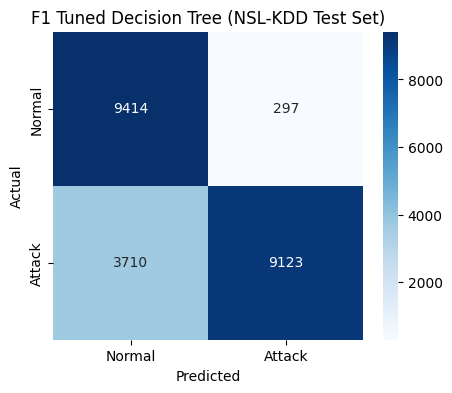

In [15]:
# Retrain best model on full training data (X_train, y_train)
final_model = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    class_weight='balanced',
    random_state=42
)

final_model.fit(X_train, y_train)

#Evaluation on Training Set
print("\nEvaluation on Training Set")
y_pred_train = final_model.predict(X_train)
calculateAndDisplayEvaluationMetrics(y_train, y_pred_train, "F1 Tuned Decision Tree (NSL-KDD Test Set)")

# Evaluation on Validation Set
print("\nEvaluation on Validation Set")
y_pred_val = final_model.predict(X_val)
calculateAndDisplayEvaluationMetrics(y_val, y_pred_val, "F1 Tuned Decision Tree (NSL-KDD Test Set)")

# Evaluation on Test Set
print("\nEvaluation on Test Set")
y_pred_test = final_model.predict(X_test)
calculateAndDisplayEvaluationMetrics(y_test, y_pred_test, "F1 Tuned Decision Tree (NSL-KDD Test Set)")